This notebook goes over all of the major components of this project:
1. Simulation: Can be thought of as a black box that takes in a solution and outputs demand coverage. Used to evaluate solutions and generate a dataset.
2. Machine learning: A multilayer perceptron (MLP) is trained to predict coverage given a solution.
3. Optimization: The MLP is embedded within a MIP which attempts to find the solution that the MLP predicts will have the highest coverage.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import matplotlib.pyplot as plt
from IPython.display import display
from ems_data import EMSData, TORONTO_AVG_CALLS_PER_DAY, TORONTO_N_AMBULANCES
from simulation import Simulation
from neural_network import *
from mip_models import *

Before doing anything, we need to load the data. The EMSData class reads and preprocesses the data for usage in simulation and MIP models.

In [2]:
# Skip this cell if you already have ems_data.pkl and don't need to regenerate with different parameters
# ems_data = EMSData(region_id=1, x_intervals=10, y_intervals=10, verbose=True)
# ems_data.save_instance('ems_data.pkl')

In [3]:
ems_data = EMSData.load_instance('ems_data.pkl')

n_stations = len(ems_data.stations)
n_demand_nodes = len(ems_data.demand_nodes)
demand = ems_data.demand_nodes.demand
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")

# stations: 46
# demand nodes: 67


In [4]:
# Problem instance parameters
N_AMBULANCES = 50
FACILITY_CAPACITY = 5
ARRIVAL_RATE = TORONTO_AVG_CALLS_PER_DAY
# MEXCLP parameters
BUSY_FRACTION = 0.75
# p-median with queuing parameters
SERVICE_RATE = 40
SUCCESS_PROB = 0.9

# Simulation
The Simulation class pulls relevant data from an EMSData instance and runs the simulation. Simulations are used to evaluate a solution (i.e., the number of ambulances at each station) as well as generate a dataset for the MLP.

In [5]:
# Pickled Simulation instance is used by HTCondor jobs
# For curating the dataset: n_days=365, n_replications=3
# For running in this notebook: n_days=100, n_replications=1
# For final results: n_days=365, n_replications=5 (maybe more)
sim = Simulation(data=ems_data, avg_calls_per_day=ARRIVAL_RATE, n_days=100, n_replications=1)
sim.save_instance('simulation.pkl')

def evaluate_solution(solution):
    """Run replication(s) and evaluate coverage and average response time.
    
    TODO: Does it make sense to sum over replications before dividing by total_arrivals, or should we compute averages within each replication first?
    """
    result = sim.run(solution)
    result = result.sum()  # Sum over replications

    total_covered = sum(result[f'n_covered_{i}'] for i in range(n_demand_nodes))
    total_response_time = sum(result[f'response_time_{i}'] for i in range(n_demand_nodes))
    total_arrivals = sum(result[f'n_arrivals_{i}'] for i in range(n_demand_nodes))
    
    coverage = total_covered / total_arrivals
    avg_response_time = total_response_time / total_arrivals

    return coverage, avg_response_time

In [6]:
# Evaluate solution that places 1 ambulance at each station
solution = [1]*n_stations
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Coverage: 0.8251360991177022
Average response time: 4.955952711273673


In [7]:
# Evaluate solution that places 1000 ambulances at each station
solution = [1000]*n_stations
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Coverage: 0.9582223888993062
Average response time: 3.4927243153133363


The dataset was generated using HTCondor and is stored in `dataset.csv`. `n_jobs = 200` jobs are run, each job performs the simulation for `solutions_per_job = 500` solutions, and `n_replications = 3` replications are ran per solution. The resulting dataset has `n_jobs * solutions_per_job` samples, one per solution (the `n_replications` replications for a solution are aggregated into a single sample).

To generate `dataset.csv`:
1. Run `htcondor_setup.py` to generate `settings<Process>.csv` files. These files contain the solutions to be simulated on each HTCondor job. For the latest dataset, I ran this:

`python htcondor_setup.py --region_id 1`

2. Move the following files to the HTCondor submit server:
    - `simulation.sub`
    - `run_job.sh`
    - `run_job.py`
    - `simulation.py`
    - `settings$(Process).csv` for each `Process`
    - `simulation.pkl`
    - `sim-env.tar.gz` (see https://chtc.cs.wisc.edu/uw-research-computing/conda-installation, Option 1; the environment must have numpy and pandas)

    The last two files go to your Squid directory (see https://chtc.cs.wisc.edu/uw-research-computing/file-avail-squid).

3. Run `condor_submit simulation.sub`. Once the jobs are done, move the `results<Process>.csv` files to a new folder on your local machine named `sim_results`.

4. Run `create_dataset.py` to create the dataset from the `results<Process>.csv` files:

`python create_dataset.py --region_id 1 --dataset_file toronto_dataset.csv`

For each solution, the script sums the `n_covered_<i>`, `response_time_<i>`, and `n_arrivals_<i>` columns over the replications, and defines `p_covered_<i> = n_covered_<i>/n_arrivals_<i>` and `avg_response_time_<i> = response_time_<i>/n_arrivals_<i>`. The resulting dataset has columns `solution_<j>` for `j` in `range(n_stations)`, `p_covered_<i>` for `i` in `range(n_demand_nodes)`, and `avg_response_time_<i>` for `i` in `range(n_demand_nodes)`.

In [8]:
# Toronto dataset settings:
# sim = Simulation(data=ems_data, avg_calls_per_day=ARRIVAL_RATE, n_days=365, n_replications=3)
# python htcondor_setup.py --region_id 1
dataset = pd.read_csv('dataset_toronto.csv')
solution_cols = dataset[[f'solution_{i}' for i in range(n_stations)]].sum(axis=1)
min_ambulances, max_ambulances = solution_cols.min(), solution_cols.max()
with pd.option_context('display.max_columns', None):
    display(dataset)

,solution_0,solution_1,solution_2,solution_3,solution_4,solution_5,solution_6,solution_7,solution_8,solution_9,solution_10,solution_11,solution_12,solution_13,solution_14,solution_15,solution_16,solution_17,solution_18,solution_19,solution_20,solution_21,solution_22,solution_23,solution_24,solution_25,solution_26,solution_27,solution_28,solution_29,solution_30,solution_31,solution_32,solution_33,solution_34,solution_35,solution_36,solution_37,solution_38,solution_39,solution_40,solution_41,solution_42,solution_43,solution_44,solution_45,coverage_0,coverage_1,coverage_2,coverage_3,coverage_4,coverage_5,coverage_6,coverage_7,coverage_8,coverage_9,coverage_10,coverage_11,coverage_12,coverage_13,coverage_14,coverage_15,coverage_16,coverage_17,coverage_18,coverage_19,coverage_20,coverage_21,coverage_22,coverage_23,coverage_24,coverage_25,coverage_26,coverage_27,coverage_28,coverage_29,coverage_30,coverage_31,coverage_32,coverage_33,coverage_34,coverage_35,coverage_36,coverage_37,coverage_38,coverage_39,coverage_40,coverage_41,coverage_42,coverage_43,coverage_44,coverage_45,coverage_46,coverage_47,coverage_48,coverage_49,coverage_50,coverage_51,coverage_52,coverage_53,coverage_54,coverage_55,coverage_56,coverage_57,coverage_58,coverage_59,coverage_60,coverage_61,coverage_62,coverage_63,coverage_64,coverage_65,coverage_66,avg_response_time_0,avg_response_time_1,avg_response_time_2,avg_response_time_3,avg_response_time_4,avg_response_time_5,avg_response_time_6,avg_response_time_7,avg_response_time_8,avg_response_time_9,avg_response_time_10,avg_response_time_11,avg_response_time_12,avg_response_time_13,avg_response_time_14,avg_response_time_15,avg_response_time_16,avg_response_time_17,avg_response_time_18,avg_response_time_19,avg_response_time_20,avg_response_time_21,avg_response_time_22,avg_response_time_23,avg_response_time_24,avg_response_time_25,avg_response_time_26,avg_response_time_27,avg_response_time_28,avg_response_time_29,avg_response_time_30,avg_response_time_31,avg_response_time_32,avg_response_time_33,avg_response_time_34,avg_response_time_35,avg_response_time_36,avg_response_time_37,avg_response_time_38,avg_response_time_39,avg_response_time_40,avg_response_time_41,avg_response_time_42,avg_response_time_43,avg_response_time_44,avg_response_time_45,avg_response_time_46,avg_response_time_47,avg_response_time_48,avg_response_time_49,avg_response_time_50,avg_response_time_51,avg_response_time_52,avg_response_time_53,avg_response_time_54,avg_response_time_55,avg_response_time_56,avg_response_time_57,avg_response_time_58,avg_response_time_59,avg_response_time_60,avg_response_time_61,avg_response_time_62,avg_response_time_63,avg_response_time_64,avg_response_time_65,avg_response_time_66
0,2,0,1,2,0,1,3,3,2,3,1,0,1,2,2,0,2,1,1,0,1,0,1,0,1,1,0,1,1,2,0,1,1,1,1,1,3,1,0,1,1,1,1,1,0,1,0.571429,0.481481,0.735690,0.822908,0.806841,0.411765,0.770050,0.858034,0.809385,0.730317,0.780334,0.924511,0.912945,0.357143,0.689309,0.748039,0.855914,0.818551,0.799740,0.928006,0.916252,0.928571,0.817755,0.882963,0.896452,0.880504,0.898565,0.939331,0.923434,0.673913,0.822695,0.864425,0.901127,0.912663,0.882579,0.911266,0.921040,0.842454,0.142857,0.836066,0.862339,0.878734,0.865620,0.815992,0.812459,0.836237,0.761677,0.546875,0.781612,0.725019,0.826929,0.874866,0.860192,0.810685,0.698507,0.585106,0.689305,0.670568,0.763821,0.775950,0.692913,0.428008,0.472118,0.603535,0.289474,0.000000,0.159091,6.855306,7.548432,5.945853,5.128758,5.324973,7.716022,5.737980,4.529217,5.428403,5.377666,5.630407,3.849265,4.284438,7.713898,6.420284,5.937474,4.843470,5.212379,5.489342,3.987188,4.311293,4.870954,5.132678,4.160652,4.322139,4.552306,4.348308,3.626687,3.940163,6.512170,5.268733,4.862597,4.145050,4.248039,4.519898,4.156319,3.884945,5.336588,8.562569,3.950357,4.627523,4.192997,4.756255,5.280997,5.226721,4.927956,5.496713,6.829160,5.257695,5.939049,4.968335,4.386101,4.650130,5.312630,6.173571,6.975430,6.331709,6.471881,5.759112,5.561177,6.467917,8.171941,7.943180,6.

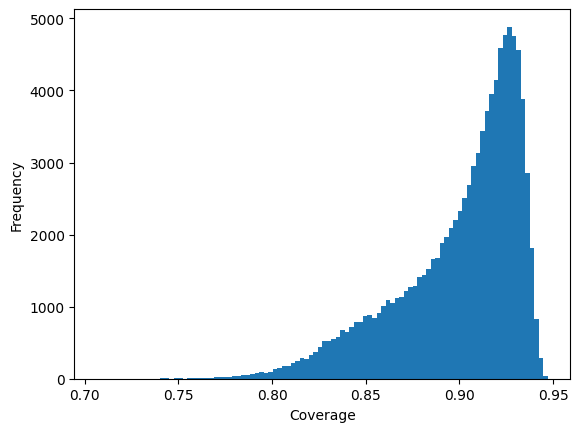

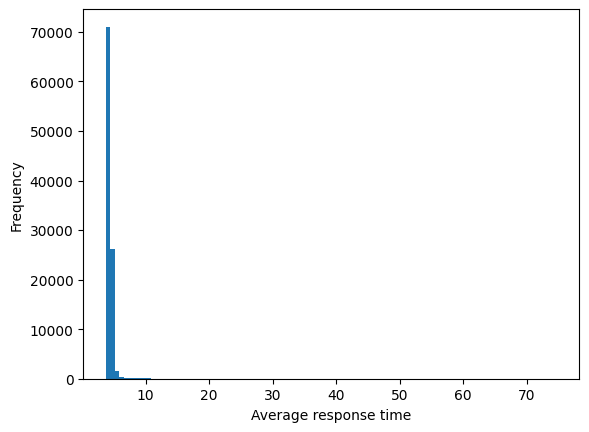

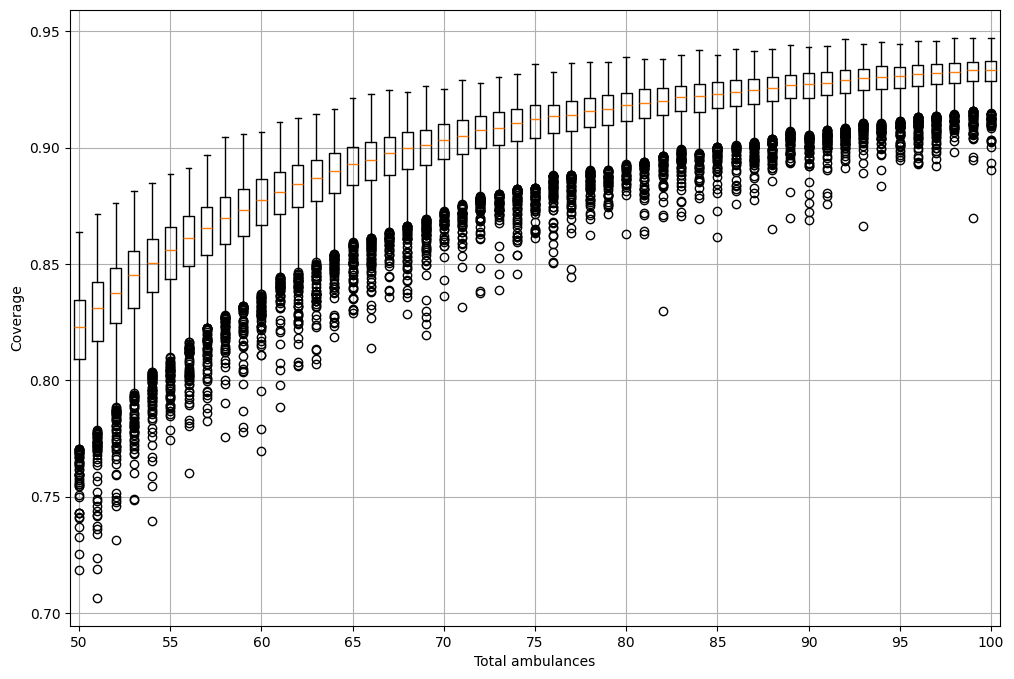

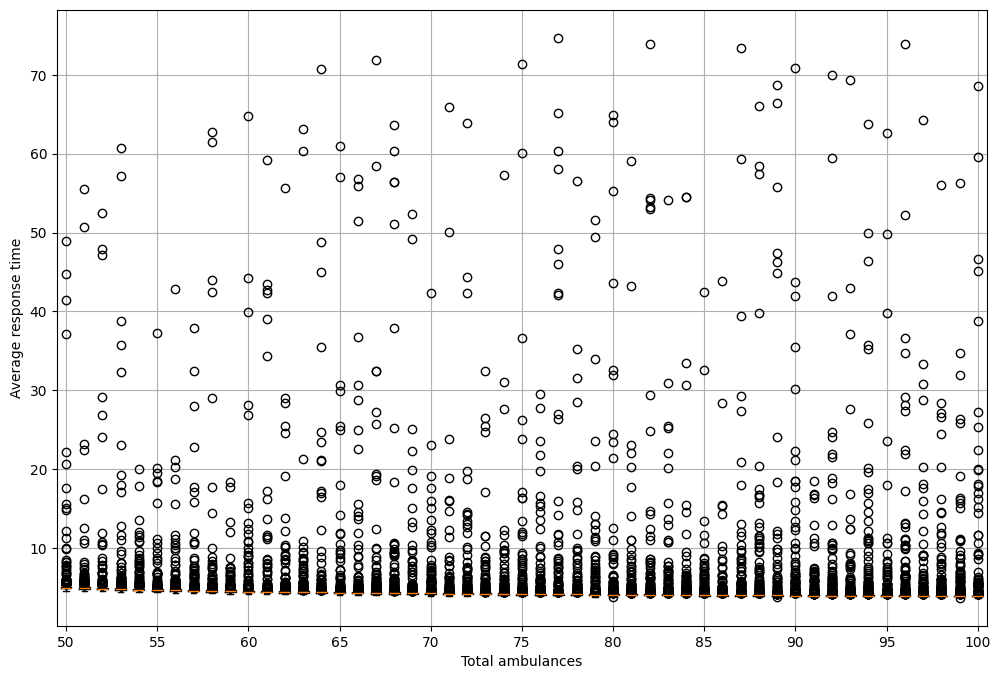

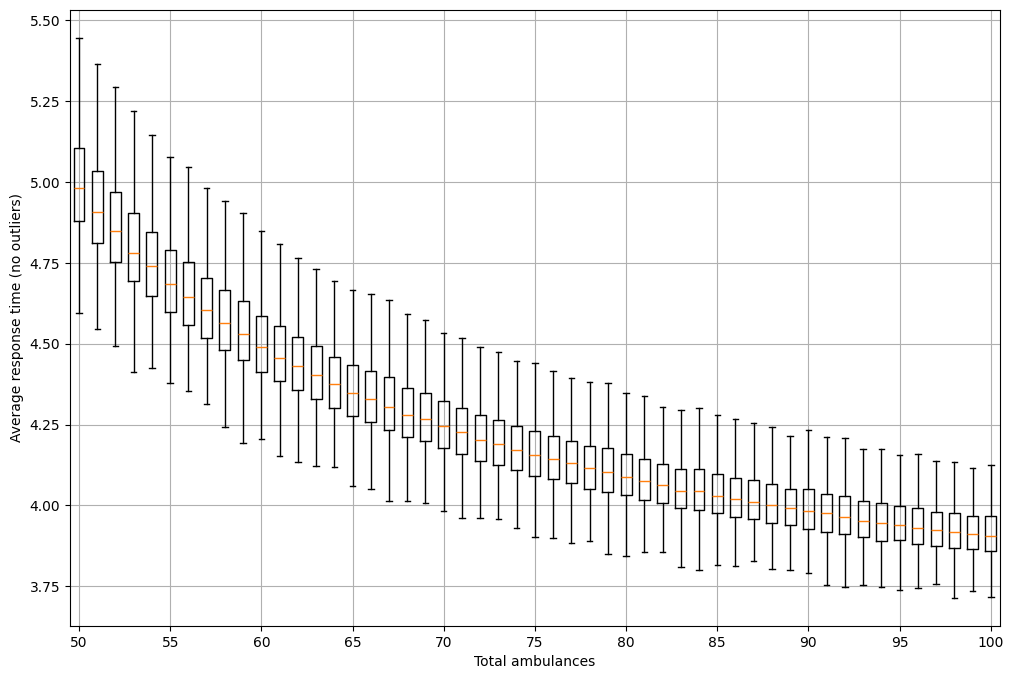

In [9]:
# Read dataset into arrays
X = dataset[[f'solution_{i}' for i in range(n_stations)]].to_numpy()
y_cov = dataset[[f'coverage_{i}' for i in range(n_demand_nodes)]].to_numpy()
y_med = dataset[[f'avg_response_time_{i}' for i in range(n_demand_nodes)]].to_numpy()

# Demand-weighting
y_cov = y_cov@demand/demand.sum()
y_med = y_med@demand/demand.sum()

# Plot histograms
plt.hist(y_cov, bins=100)
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.show()

plt.hist(y_med, bins=100)
plt.xlabel("Average response time")
plt.ylabel("Frequency")
plt.show()

# To see how metrics improve with more ambulances, plot box plots, one for each total number of ambulances
def plot_boxplots(X, y, ylabel, showfliers=True):
    """Note: Function needs X argument in case outliers are removed."""
    data_to_plot = [y[X.sum(axis=1) == total] for total in range(min_ambulances, max_ambulances+1)]
    plt.figure(figsize=(12, 8))
    plt.boxplot(data_to_plot, positions=range(min_ambulances, max_ambulances+1), widths=0.6, showfliers=showfliers)
    plt.xlabel("Total ambulances")
    plt.ylabel(ylabel)
    plt.xticks(range(min_ambulances, max_ambulances+1, 5), range(min_ambulances, max_ambulances+1, 5))
    plt.grid(True)
    plt.show()

plot_boxplots(X, y_cov, "Coverage")
plot_boxplots(X, y_med, "Average response time")
plot_boxplots(X, y_med, "Average response time (no outliers)", False)

Even though coverage data seems to be relatively free of outliers, average response time data has a long right tail. From the box plots, we see that this is due to outliers which can be found over all total ambulance values. This skew makes it difficult to train the model.

One possible solution is applying a power transformation to the target. Even though the model's predictions will be in the transformed space, the MIP model is attempting to find a minimizer, so as long as the function is strictly monotone, it is not necessary to model the inverse function in the MIP model. Therefore, is successful, there are no obvious downsides to applying a power transformation to the target.

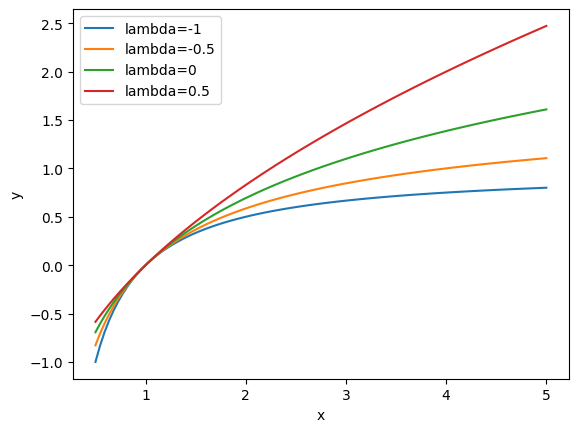

In [10]:
# Box-Cox transformation for different lambda values, note that each function is monotonically increasing
x = np.linspace(0.5, 5, 100)
for lmbda in [-1, -0.5, 0, 0.5]:
    y = stats.boxcox(x, lmbda=lmbda)
    plt.plot(x, y, label=f"lambda={lmbda}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.legend()

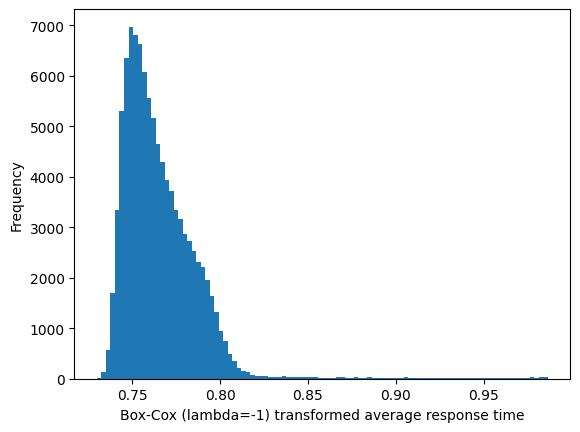

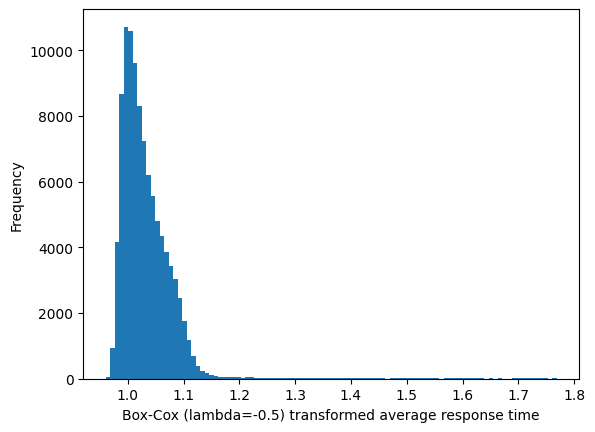

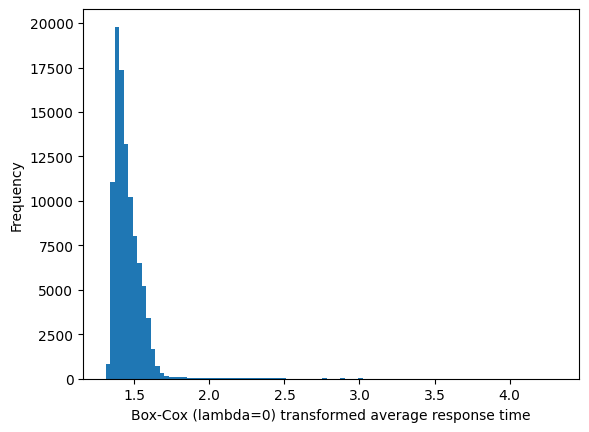

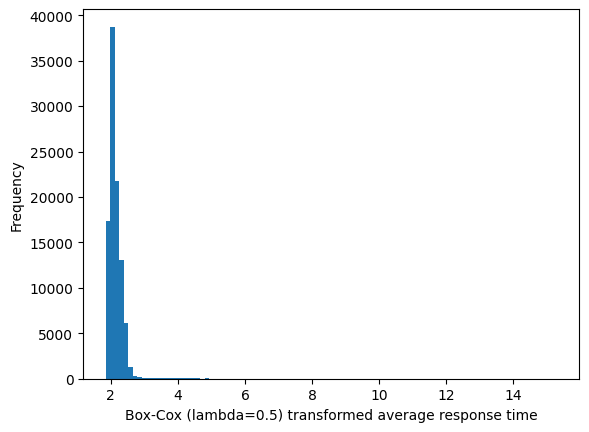

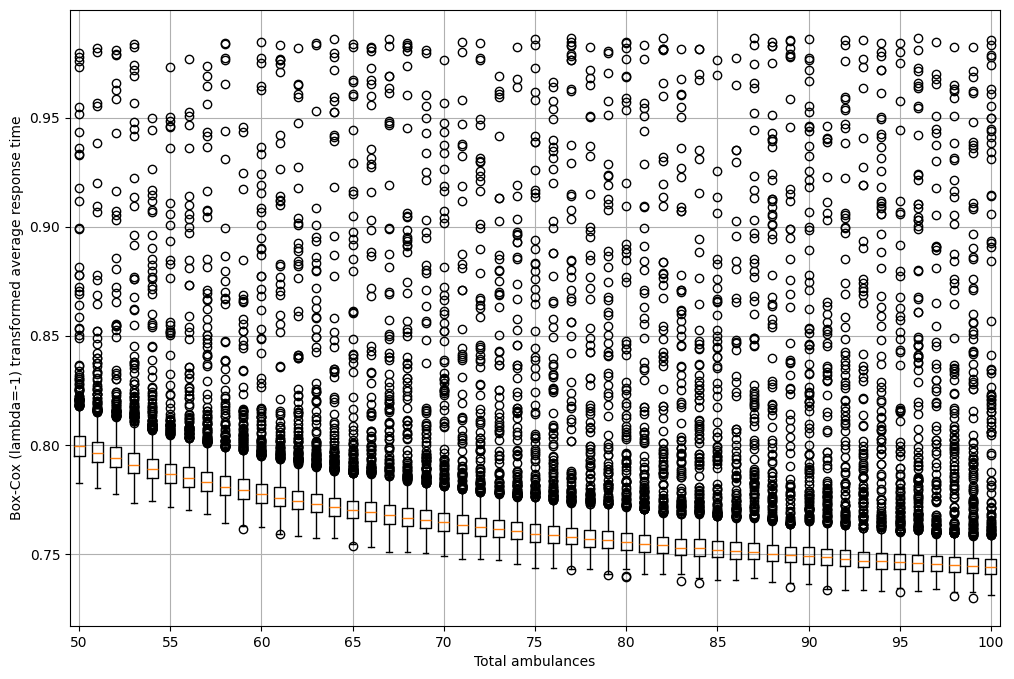

In [11]:
# Plot histogram of transformed target for different lambda values
for lmbda in [-1, -0.5, 0, 0.5]:
    y_med_bc = stats.boxcox(y_med, lmbda=lmbda)
    plt.hist(y_med_bc, bins=100)
    plt.xlabel(f"Box-Cox (lambda={lmbda}) transformed average response time")
    plt.ylabel("Frequency")
    plt.show()

# Plot box plots of transformed target, only for lambda=-1
plot_boxplots(X, stats.boxcox(y_med, lmbda=-1), "Box-Cox (lambda=-1) transformed average response time")

Even though there's improvement, the long tail on the histogram and outliers on the box plots don't go away even when using $\lambda=-1$, the most extreme transformation. We conclude that power transformation isn't enough.

We consider removing outliers. Unlike power transformation, there is an obvious downside to removing outliers: we are losing training data. This loss in data cannot be compensated for by collecting more samples, as by removing outlier from the dataset, we are depriving the ML model of the ability to learn from them. However, we will find empirically that the ML model still performs well when embedded in the MIP.

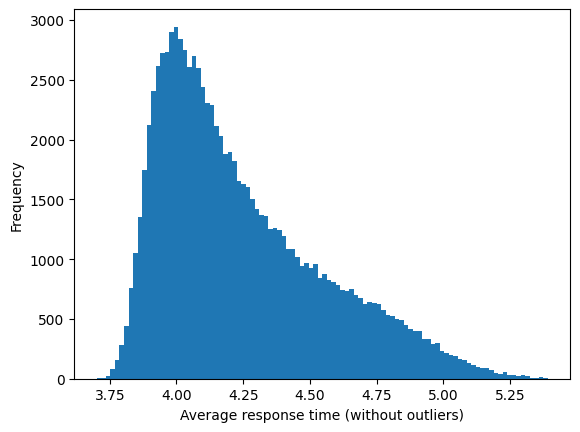

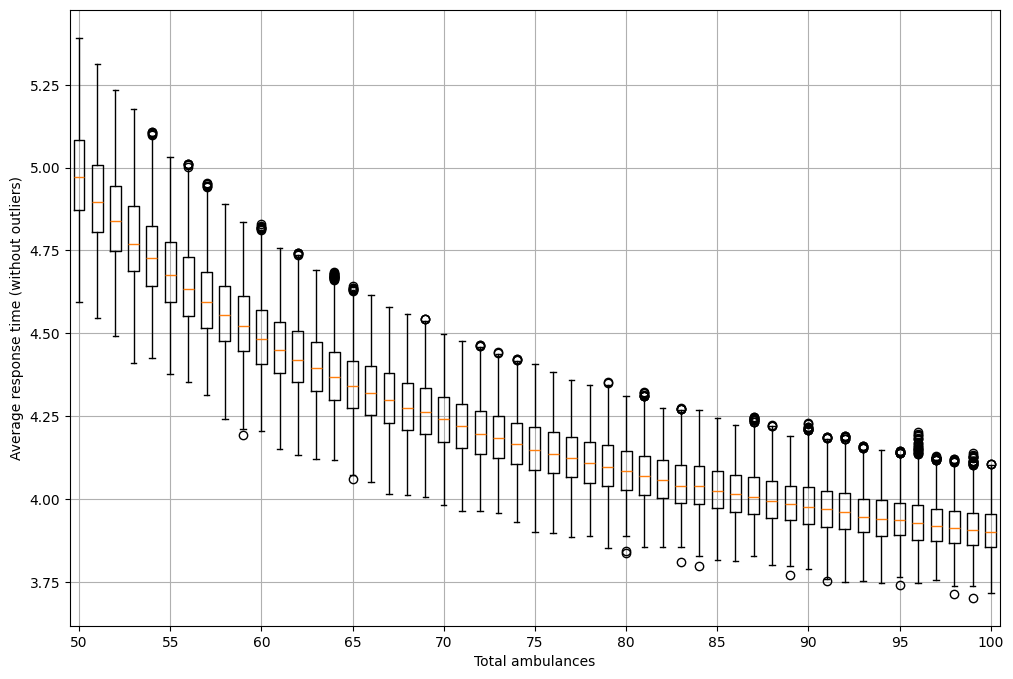

In [12]:
# Remove outliers from y_med

# Not as simple as just removing the top x% as follows:
# percentile = 95
# threshold = np.percentile(y_med, percentile)
# X_med = X[y_med < threshold]
# y_med = y_med[y_med < threshold]

# Need to instead isolate only the samples using the same total number of ambulances, then remove outliers
percentile = 95
keep = np.full(X.shape[0], False)
for total in range(min_ambulances, max_ambulances+1):
    threshold = np.percentile(y_med[X.sum(axis=1) == total], percentile)
    keep |= (X.sum(axis=1) == total) & (y_med < threshold)
X_med = X[keep]
y_med = y_med[keep]

# Histogram without outliers
plt.hist(y_med, bins=100)
plt.xlabel("Average response time (without outliers)")
plt.ylabel("Frequency")
plt.show()

# Box plots without outliers
plot_boxplots(X_med, y_med, "Average response time (without outliers)")

# Machine Learning
The MLP takes as input the solution and outputs the coverage probabilities for each demand node.

In [13]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [14]:
# Move dataset into tensors compatible with model and split into train/dev sets (no test set)
X_cov = torch.tensor(X, dtype=torch.float32, device=device)
y_cov = torch.tensor(y_cov, dtype=torch.float32, device=device)
X_med = torch.tensor(X_med, dtype=torch.float32, device=device)
y_med = torch.tensor(y_med, dtype=torch.float32, device=device)

In [15]:
# Train MLP for coverage model
mlp = MLP(
    in_dim=n_stations,
    hidden_dims=[200],
    demand=demand,
    model_type='coverage',
    name='coverage'
).to(device)
mlp.fit(X_cov, y_cov)

 76%|███████▋  | 153/200 [05:04<01:33,  1.99s/epoch, best_val_loss=2.09e-6, train_loss=1.68e-6, val_loss=2.32e-6] 

Early stopping


In [16]:
# Switch to SGD with momentum and continue training
mlp.set_dropout(0)
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'lr': 1e-2, 'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'threshold': 1e-3}
)
mlp.fit(X_cov, y_cov)
mlp.save_npz()

100%|██████████| 200/200 [05:57<00:00,  1.79s/epoch, best_val_loss=1.27e-6, train_loss=1.25e-6, val_loss=1.27e-6]


In [17]:
# Train MLP for median model
mlp = MLP(
    in_dim=n_stations,
    hidden_dims=[200],
    demand=demand,
    model_type='p-median',
    name='pmedian'
).to(device)
mlp.fit(X_med, y_med)

 62%|██████▏   | 124/200 [03:44<02:17,  1.81s/epoch, best_val_loss=0.000812, train_loss=0.000781, val_loss=0.000973]

Early stopping


In [18]:
# Switch to SGD with momentum and continue training
mlp.set_dropout(0)
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'lr': 1e-2, 'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'threshold': 1e-3}
)
mlp.fit(X_med, y_med)
mlp.save_npz()

 12%|█▎        | 25/200 [00:41<04:51,  1.66s/epoch, best_val_loss=0.000619, train_loss=0.0006, val_loss=0.000622]  

Early stopping


# Optimization
The trained MLP is embedded within a MIP which attempts to find the solution that the MLP predicts will have the highest coverage.

In [13]:
# Find the best solutions from the dataset
X = dataset[[f'solution_{i}' for i in range(n_stations)]].to_numpy()
y_cov = dataset[[f'coverage_{i}' for i in range(n_demand_nodes)]].to_numpy()
y_med = dataset[[f'avg_response_time_{i}' for i in range(n_demand_nodes)]].to_numpy()
y_cov = y_cov@demand/demand.sum()
y_med = y_med@demand/demand.sum()

# Best w.r.t. coverage
best_idx = np.argmax(y_cov)
solution = X[best_idx]
print(f"Best w.r.t. coverage: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

# Best w.r.t. average response time
best_idx = np.argmin(y_med)
solution = X[best_idx]
print(f"Best w.r.t. average response time: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

# Best w.r.t. coverage, at most N_AMBULANCES ambulances
indices = np.where(X.sum(axis=1) <= N_AMBULANCES)[0]
best_idx = indices[np.argmax(y_cov[indices])]
solution = X[best_idx]
print(f"Best w.r.t. coverage, at most {N_AMBULANCES} ambulances: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

# Best w.r.t. average response time, at most N_AMBULANCES ambulances
indices = np.where(X.sum(axis=1) <= N_AMBULANCES)[0]
best_idx = indices[np.argmin((y_med)[indices])]
solution = X[best_idx]
print(f"Best w.r.t. average response time, at most {N_AMBULANCES} ambulances: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Best w.r.t. coverage: [1 2 3 3 1 2 1 4 3 1 2 1 1 2 1 2 2 3 2 1 3 3 1 1 3 2 2 2 4 1 4 3 1 4 2 2 2
 1 3 2 6 2 2 2 2 1]
Total ambulances used: 99
Coverage: 0.9487638501545187
Average response time: 3.690016807143229
Best w.r.t. average response time: [1 2 3 3 1 2 1 4 3 1 2 1 1 2 1 2 2 3 2 1 3 3 1 1 3 2 2 2 4 1 4 3 1 4 2 2 2
 1 3 2 6 2 2 2 2 1]
Total ambulances used: 99
Coverage: 0.9462325512048754
Average response time: 3.709965519862587
Best w.r.t. coverage, at most 50 ambulances: [1 1 1 1 1 2 2 1 1 1 2 1 0 1 1 1 3 1 0 0 1 1 1 1 0 2 1 2 1 1 2 1 1 0 1 1 1
 2 2 1 1 1 2 1 0 0]
Total ambulances used: 50
Coverage: 0.8642151791592213
Average response time: 4.572617351141748
Best w.r.t. average response time, at most 50 ambulances: [1 1 1 1 1 2 2 1 1 1 2 1 0 1 1 1 3 1 0 0 1 1 1 1 0 2 1 2 1 1 2 1 1 0 1 1 1
 2 2 1 1 1 2 1 0 0]
Total ambulances used: 50
Coverage: 0.8651588300490297
Average response time: 4.582784565663406


In [14]:
# Daskin's MEXCLP model
solution, objective_value = mexclp(
    demand=demand,
    distance=ems_data.demand_node_to_station_times,
    threshold=ems_data.response_time_threshold,
    n_ambulances=N_AMBULANCES,
    busy_fraction=BUSY_FRACTION,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 68 rows, 3396 columns and 4008 nonzeros
Model fingerprint: 0x9954154f
Variable types: 0 continuous, 3396 integer (3350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-13, 2e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 866 columns
Presolve time: 0.01s
Presolved: 68 rows, 2530 columns, 3130 nonzeros
Variable types: 0 continuous, 2530 integer (2480 binary)
Found heuristic solution: objective 0.4980825

Root relaxation: objective 9.752344e-01, 382 iterations, 0.00 seconds (0.00 work units)



In [15]:
# p-Median with queuing
arrival_rates = ARRIVAL_RATE*np.array(demand)/demand.sum()
rho = compute_rho(max_servers=FACILITY_CAPACITY, success_prob=SUCCESS_PROB)
solution, objective_value = pmedian_with_queuing(
    demand=demand,
    distance=ems_data.demand_node_to_station_times,
    n_ambulances=N_AMBULANCES,
    arrival_rates=arrival_rates,
    service_rate=SERVICE_RATE,
    rho=rho,
    time_limit=60
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Set parameter TimeLimit to value 60


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3380 rows, 3312 columns and 13156 nonzeros
Model fingerprint: 0x15971ae5
Variable types: 3082 continuous, 230 integer (230 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+01]
  Objective range  [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 11.2950571
Presolve time: 0.01s
Presolved: 3380 rows, 3312 columns, 13156 nonzeros
Variable types: 3082 continuous, 230 integer (230 binary)

Root relaxation: objective 3.234137e+00, 230 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.23414    0  129   11.29506    3.2341

In [16]:
# Coverage-MLP
weights, biases = MLP.load_npz('coverage.npz')
solution = mlp_based_model(
    model_type='coverage',
    weights=weights,
    biases=biases,
    n_ambulances=N_AMBULANCES,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1785 rows, 893 columns and 26080 nonzeros
Model fingerprint: 0x9f38b47e
Variable types: 647 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [3e-06, 6e+01]
  Objective range  [3e-06, 7e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e-03, 6e+01]
Presolve removed 180 rows and 113 columns
Presolve time: 0.06s
Presolved: 1605 rows, 780 columns, 25787 nonzeros
Variable types: 534 continuous, 246 integer (200 binary)

Root relaxation: objective 9.545468e-01, 1941 iterations, 0.14 seconds (0.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.95455   

In [17]:
# Median-MLP
weights, biases = MLP.load_npz('pmedian.npz')
solution = mlp_based_model(
    model_type='p-median',
    weights=weights,
    biases=biases,
    n_ambulances=N_AMBULANCES,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Coverage: {coverage}\nAverage response time: {avg_response_time}")

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1115 rows, 893 columns and 24740 nonzeros
Model fingerprint: 0x7ec0c9a4
Variable types: 647 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+01]
  Objective range  [3e-06, 7e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e-03, 5e+01]
Presolve removed 247 rows and 180 columns
Presolve time: 0.03s
Presolved: 868 rows, 713 columns, 24313 nonzeros
Variable types: 467 continuous, 246 integer (200 binary)

Root relaxation: objective 4.253688e+00, 606 iterations, 0.02 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.25369    0

Next steps: Arrivals follow a general distribution, not necessarily memoryless. Right now we sample from historical arrival times so general is more appropriate than memoryless. Could implement an extreme case where there are zero/few arrivals for 23 hours of the day and then 1 hour gets a ton of arrivals. Base model (p-median + queuing) takes an arrival rate as a parameter, what should this be? Average daily arrival rate, or peak arrival rate? Advantage of neural net is we can support any arrival/service distribution.